In [1]:
import warnings; warnings.simplefilter('ignore') #for PCoA warnings

import pandas as pd
import numpy as np
import os

#import data
from biom import load_table
from gneiss.util import match
#deicode
from deicode.optspace import OptSpace
from deicode.preprocessing import rclr
#skbio
from skbio import DistanceMatrix
from skbio.stats.ordination import pcoa
from scipy.spatial.distance import pdist
from skbio.stats.distance import permanova
from skbio.stats.composition import clr,centralize
#plotting
import seaborn as sns
import matplotlib.pyplot as plt
from deicode.utils import get_enriched_labels,get_mean_abundance,get_lowest_level,get_taxa
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
from matplotlib import ticker
import matplotlib.colors as mcolors
plt.style.use('seaborn-paper')

%matplotlib inline

## Import the case studies

In [2]:
# empty dict to save each case study in 
case_study={}
for dataset_ in [dir_ for dir_ in os.listdir('data/') if dir_!='.DS_Store']:
    #import and filter samples for >500 reads/sample
    in_biom = os.path.join('data',dataset_,'table.biom')
    table = load_table(in_biom)
    sample_filter = lambda val, id_, md: sum(val) > 500
    table = table.filter(sample_filter, axis='sample')
    table_df=table.to_dataframe().T.drop_duplicates()    
    # Get OTU to taxa match
    taxonomy=get_taxa(table.metadata_to_dataframe('observation'))    
    # Get metadata for table 
    mapping_df=pd.read_table(os.path.join('data',dataset_,'metadata.txt')
                             ,index_col=0)
    # Match the tables 
    table_df,mapping_df=match(table_df,mapping_df)
    # ensure after filtering there are no all 0 count OTUs
    table_df=table_df.T[table_df.sum()>0].T
    case_study[dataset_]={'table':table_df,
                         'metadata':mapping_df,
                         'taxonomy':taxonomy}
        

## Add metadata of interest for each

In [3]:
case_study['Sponges']['factor']='host_status'
case_study['Infants']['factor']='solid_food'
case_study['Sleep_Apnea']['factor']='exposure_type'


## Run distances for each

In [4]:
for study_,rank_ in zip(case_study.keys(),[2,3,2]):
    
    table_tmp=case_study[study_]['table'].copy()
    # rclr preprocessing
    table_norm=rclr().fit_transform(table_tmp.copy())
    
    # OptSpace (RPCA)
    opt=OptSpace(rank=rank_).fit(table_norm) 
    #Sample Loadings 
    sample_loading=pd.DataFrame(opt.sample_weights,index=table_tmp.index)
    sample_loading = sample_loading.rename(columns={0: 'PC1', 1: 'PC2', 2:'PC3'})
    #Feature Loadings 
    feature_loading=pd.DataFrame(opt.feature_weights
                             ,index=table_tmp.columns).sort_values(by=0)
    # save all RPCA output
    case_study[study_]['RPCA_features']=feature_loading
    case_study[study_]['RPCA_samples']=sample_loading
    case_study[study_]['RPCA_dist']=DistanceMatrix(opt.distance
                                                   ,list(table_tmp.index))
    # Bray-Curtis 
    bray_dist=pdist(table_tmp.copy().as_matrix(), 'braycurtis')
    case_study[study_]['Bray_Curtis_dist']=DistanceMatrix(bray_dist
                                                          ,list(table_tmp.index))
    # Import UniFrac (processed in Qiita)
    in_uni=os.path.join('data',study_,'Qiita_wieghted_unifrac.tsv')
    unifrac_weighted_dist=pd.read_csv(in_uni,index_col=0)
    unifrac_weighted_dist=unifrac_weighted_dist.reindex(index=table_tmp.index
                                                        ,columns=table_tmp.index)
    case_study[study_]['Weighted_UniFrac_dist']=DistanceMatrix(unifrac_weighted_dist
                                                          ,list(table_tmp.index))



## PERMANOVA Analysis 

In [5]:
permanova_results={}
for study_ in case_study.keys():
    permanova_results[study_]={}
    uniperm=permanova(case_study[study_]['Weighted_UniFrac_dist']
              ,case_study[study_]['metadata'][case_study[study_]['factor']].values)
    
    brayperm=permanova(case_study[study_]['Bray_Curtis_dist']
              ,case_study[study_]['metadata'][case_study[study_]['factor']].values)

    atchperm=permanova(case_study[study_]['RPCA_dist']
              ,case_study[study_]['metadata'][case_study[study_]['factor']].values)
        
    permanova_results[study_][('Robust Aitchison','p-value')]=atchperm['p-value']
    permanova_results[study_][('Robust Aitchison','F statistic')]=atchperm['test statistic']
    permanova_results[study_][('Weighted Unifrac','p-value')]=uniperm['p-value']
    permanova_results[study_][('Weighted Unifrac','F statistic')]=uniperm['test statistic']
    permanova_results[study_][('Bray-Curtis','p-value')]=brayperm['p-value']
    permanova_results[study_][('Bray-Curtis','F statistic')]=brayperm['test statistic']
      
permanova_results_df=pd.DataFrame(permanova_results).T
permanova_results_df.to_csv('figures/table_1.csv')
permanova_results_df


Bray-Curtis         Robust Aitchison         Weighted Unifrac  \
            F statistic p-value      F statistic p-value      F statistic   
Infants        9.250355   0.001        44.157634   0.001        20.944733   
Sleep_Apnea    9.540282   0.001        84.626234   0.001         5.765629   
Sponges       54.002632   0.001       276.949199   0.001        89.019267   

                     
            p-value  
Infants       0.001  
Sleep_Apnea   0.002  
Sponges       0.001

## Ordination Visualization

In [226]:
def plot_pcoa(samples, md, ax, factor_, colors_map):
    """ 
    Parameters
    ----------
    samples : pd.DataFrame
        Contains PCoA coordinates
    md : pd.Dataframe
        Metadata object
    ax : matplotlib.Axes
        Contains matplotlib axes object
    """
    classes=list(set(md[factor_].values))

    cmap_out={}
    for sub_class,color_ in zip(classes,colors_map):
        idx = md[factor_] == sub_class
        ax.scatter(samples.loc[idx, 'PC2'],
           samples.loc[idx, 'PC1'], 
           label=sub_class,
           facecolors=color_,
           edgecolors=color_,
           alpha=.38,linewidth=3)        
        cmap_out[sub_class]=color_
    ax.grid()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    return ax,cmap_out

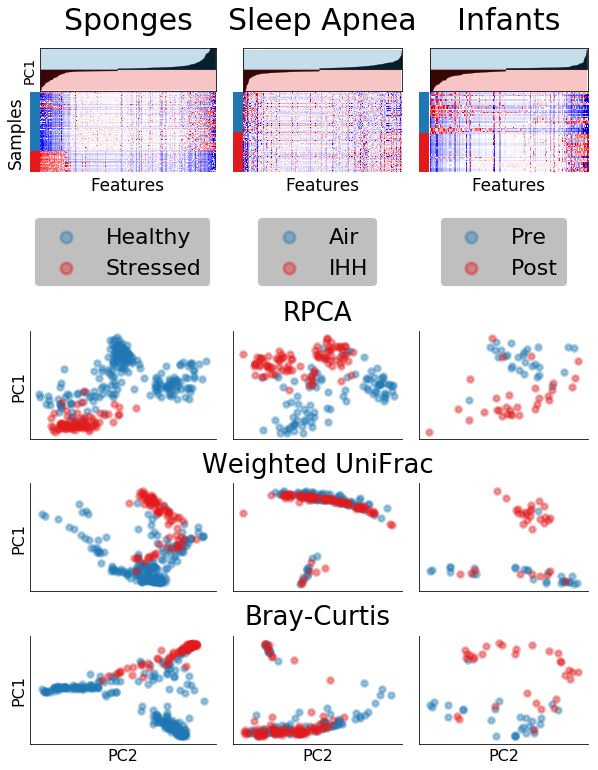

In [236]:
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))


fig = plt.figure(figsize=(10, 13), facecolor='white')
gs = gridspec.GridSpec(130, 55*len(case_study.keys()))
width_start=0
width_end=55
heat_bars=3
colors_map=['#1f78b4','#e31a1c']

for count_,study_ in enumerate(case_study.keys()): 

    ax_map = plt.subplot(gs[8:23, width_start+heat_bars:width_end])
    ax_map_bar = plt.subplot(gs[8:23, width_start:width_start+heat_bars])
    ax_bar = plt.subplot(gs[0:8, width_start+heat_bars:width_end])
    #if count_==len(case_study.keys())-1:
    #    ax_cbar = plt.subplot(gs[8:23, 55*len(case_study.keys())+5:])
    ax_raw_RPCA = plt.subplot(gs[52:72, width_start:width_end])
    ax_raw_WU = plt.subplot(gs[80:100, width_start:width_end])
    ax_raw_BC = plt.subplot(gs[108:128, width_start:width_end])
        
    # plot bar
    feature_loading=case_study[study_]['RPCA_features']
    feature_loading=feature_loading[abs(feature_loading[0])>abs(feature_loading[0]).mean()+.3]
    ind = np.arange(feature_loading.shape[0])
    ax_bar.stackplot(ind, feature_loading[0],color='black',alpha=1)
    ax_bar.set_xlim([0, feature_loading.shape[0]])
    ax_bar.set_ylim([feature_loading[0].min(), feature_loading[0].max()])
    ax_bar.set_xticks([])
    ax_bar.set_ylim([-10, 10])
    ax_bar.grid(which='major', axis='both', linestyle='--')
    if count_==0:
        ax_bar.set_ylabel('PC1', fontsize=14)
    if count_==2:
        ax_bar.set_yticks([])
        #ax_bar.set_ylabel('PC1', fontsize=14)
        #ax_bar.yaxis.set_label_position("right")
    else:
        ax_bar.set_yticks([])
    ax_bar.tick_params(labelsize=8)
    ax_bar.fill_between(ind, 0.1,feature_loading[0].max(), color=colors_map[0],alpha=.25)  
    ax_bar.fill_between(ind, -0.1,feature_loading[0].min(), color=colors_map[1],alpha=.25)  
    ax_bar.set_title(study_.replace('_',' '),fontsize=30,y=1.3)

    # plot map
    table_tmp=case_study[study_]['table'].copy()
    sort_meta=case_study[study_]['metadata'][case_study[study_]['factor']].sort_values()
    sorted_df = table_tmp.reindex(index=sort_meta.index, columns=feature_loading.index)
    sorted_df = sorted_df.loc[:, sorted_df.sum(axis=0) > 10] #make clusters more evident 
    img = ax_map.imshow(clr(centralize(sorted_df+1)), aspect='auto', 
                        norm=MidpointNormalize(midpoint=0.),
                        interpolation='nearest', cmap='seismic')
    ax_map.set_xticks([])
    ax_map.set_yticks([])
    if count_==0:
        ax_map.set_ylabel('Samples', fontsize=17,labelpad=15)
    ax_map.set_xlabel('Features', fontsize=17)
    ax_map.spines['right'].set_visible(False)
    ax_map.spines['top'].set_visible(False)
    ax_map.spines['bottom'].set_visible(False)
    ax_map.spines['left'].set_visible(False)
    ax_map.grid()
    
    # plot RPCA
    _,cmap_out=plot_pcoa(case_study[study_]['RPCA_samples'], 
               case_study[study_]['metadata'], 
               ax_raw_RPCA,case_study[study_]['factor'],colors_map)
    ax_raw_RPCA.legend(loc='upper center', 
                           bbox_to_anchor=(0.5, 2.15),
                           prop={'size':22},
                         fancybox=True, framealpha=0.5,ncol=1
                         , markerscale=2, facecolor="grey")
    
    # color map-bars
    unique_values = sorted(set(sort_meta.values)) 
    colors_map=list(cmap_out.values())
    vmap = { c : i for i, c in enumerate(unique_values) }
    mapper = lambda t: vmap[str(t)]
    cmap_object = mcolors.LinearSegmentedColormap.from_list('custom', colors_map, N=len(colors_map))
    sns.heatmap(pd.DataFrame(sort_meta).applymap(mapper), 
                cmap=cmap_object,ax=ax_map_bar,
                yticklabels=False,xticklabels=False,cbar=False)
    ax_map_bar.set_xlabel('')
    ax_map_bar.set_ylabel('')
    
    # plot WU
    plot_tmp=pcoa(case_study[study_]['Weighted_UniFrac_dist']).samples
    plot_pcoa(plot_tmp, 
               case_study[study_]['metadata'], 
               ax_raw_WU,case_study[study_]['factor'],colors_map)
  
    # plot BC
    plot_tmp=pcoa(case_study[study_]['Bray_Curtis_dist']).samples
    plot_pcoa(plot_tmp, 
               case_study[study_]['metadata'], 
               ax_raw_BC,case_study[study_]['factor'],colors_map)
    
    if count_==0:
        ax_raw_RPCA.set_ylabel('PC1', fontsize=16)
        ax_raw_WU.set_ylabel('PC1', fontsize=16)
        ax_raw_BC.set_ylabel('PC1', fontsize=16)
    if count_==1:
        ax_raw_RPCA.set_title('RPCA',y=1.05, fontsize=26)
        ax_raw_WU.set_title('Weighted UniFrac',y=1.05, fontsize=26)
        ax_raw_BC.set_title('Bray-Curtis',y=1.05, fontsize=26)        
        
    ax_raw_BC.set_xlabel('PC2', fontsize=16)
    
    # iterate and make new width limits    
    width_start=width_end+5
    width_end+=width_end
    
fig.savefig('figures/figure3.png',dpi=300, bbox_inches='tight',facecolor='white')
plt.show()


## Get taxanomic Differences

In [228]:
from skbio.stats.composition import closure


In [254]:
def plot_biplot(samples, md, ax, factor_, y_axis_, marker_map=["o","^","s"],cmap_=plt.cm.RdBu):
    """ 
    Parameters
    ----------
    samples : pd.DataFrame
        Contains PCoA coordinates
    md : pd.Dataframe
        Metadata object
    ax : matplotlib.Axes
        Contains matplotlib axes object
    """
    classes=list(set(md[factor_].values))
    for sub_class,marker_ in zip(classes,marker_map):
        idx = md[factor_] == sub_class
        ax.scatter(samples.loc[idx, y_axis_],
           samples.loc[idx, 'PC1'], 
           label=sub_class,
           c=samples.loc[idx, y_axis_],
           cmap=cmap_,  
           marker=marker_,
           alpha=.9,s=300)     
    ax.grid()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_yticks([])
    ax.xaxis.set_tick_params(labelsize=20)
    return ax

In [253]:
level='lowest'
N_show=3 #number of top&bottom to show
axis_sort=0

for count_,study_ in enumerate(case_study.keys()): 


    # import 
    table_tmp=case_study[study_]['table'].copy()
    factor_=case_study[study_]['factor']
    taxa_tmp=case_study[study_]['taxonomy'].copy().drop('taxonomy',axis=1)
    meta_tmp=case_study[study_]['metadata'].copy()
    feature_load=case_study[study_]['RPCA_features'].copy()
    sample_load=case_study[study_]['RPCA_samples'].copy()

    # convert unknown taxa to "other"
    mask=np.array([list(taxa_tmp[l].str.len().values) 
                  for l in taxa_tmp.columns]).T
    mask=pd.DataFrame(mask,taxa_tmp.index,taxa_tmp.columns)
    taxa_tmp[mask<=3]=np.nan
    lowest_assigned=taxa_tmp.ffill(axis=1).iloc[:, -1] 
    taxa_tmp[mask<=3]='__Unclassified'
    taxa_tmp['lowest']=[x.split('__')[1]+'('+x.split('__')[0]+')_{ID:'+str(y)+'}'
                        for x,y in zip(lowest_assigned,lowest_assigned.index)]

    # concat features 
    feature_taxa=pd.concat([feature_load,taxa_tmp],axis=1).dropna(subset=[axis_sort]).sort_values(axis_sort)
    # level groupby
    level_grouping={level_:feature_taxa.groupby(level_).sum().sort_values(axis_sort) for level_ in taxa_tmp.columns}
    # taxa levels
    top=[]
    top_otus={}
    bottom=[]
    bottom_otus={}
    for i in range(N_show):
        top_=level_grouping[level].iloc[[i]].index[0]
        bottom_=level_grouping[level].iloc[[-(i+1)]].index[0]
        top.append(top_)
        bottom.append(bottom_)
        top_otus[top_]=list(feature_taxa[feature_taxa[level].isin([top_])].index)
        bottom_otus[bottom_]=list(feature_taxa[feature_taxa[level].isin([bottom_])].index)
    # get table of ratios 
    log_ratios=[]
    for (count_,(x_i,x_i_features)),(y_j,y_j_features) in zip(enumerate(top_otus.items()),bottom_otus.items()):
        x_i_vector=table_tmp.loc[:, x_i_features]
        y_j_vector=table_tmp.loc[:, y_j_features]
        x_i_vector=x_i_vector[x_i_vector.T.sum()>0]
        y_j_vector=y_j_vector[y_j_vector.T.sum()>0]
        b = (np.log(x_i_vector+1).mean(axis=1) -
             np.log(y_j_vector+1).mean(axis=1))
        log_ratios.append(pd.DataFrame(b,columns=['ln(\dfrac{'+x_i.replace('__','')+'}{'+y_j.replace('__','')+'})']))
    log_ratios=pd.concat(log_ratios,axis=1)
    ratios_=log_ratios.columns
    log_ratios[factor_]=meta_tmp.reindex(log_ratios.index)[factor_]
    log_ratios=pd.concat([log_ratios,sample_load],axis=1)
    log_ratios['sample_ids']=log_ratios.index
    log_ratios.reset_index(inplace=True,drop=True)
    case_study[study_]['lr']=log_ratios
    case_study[study_]['lr_list']=ratios_


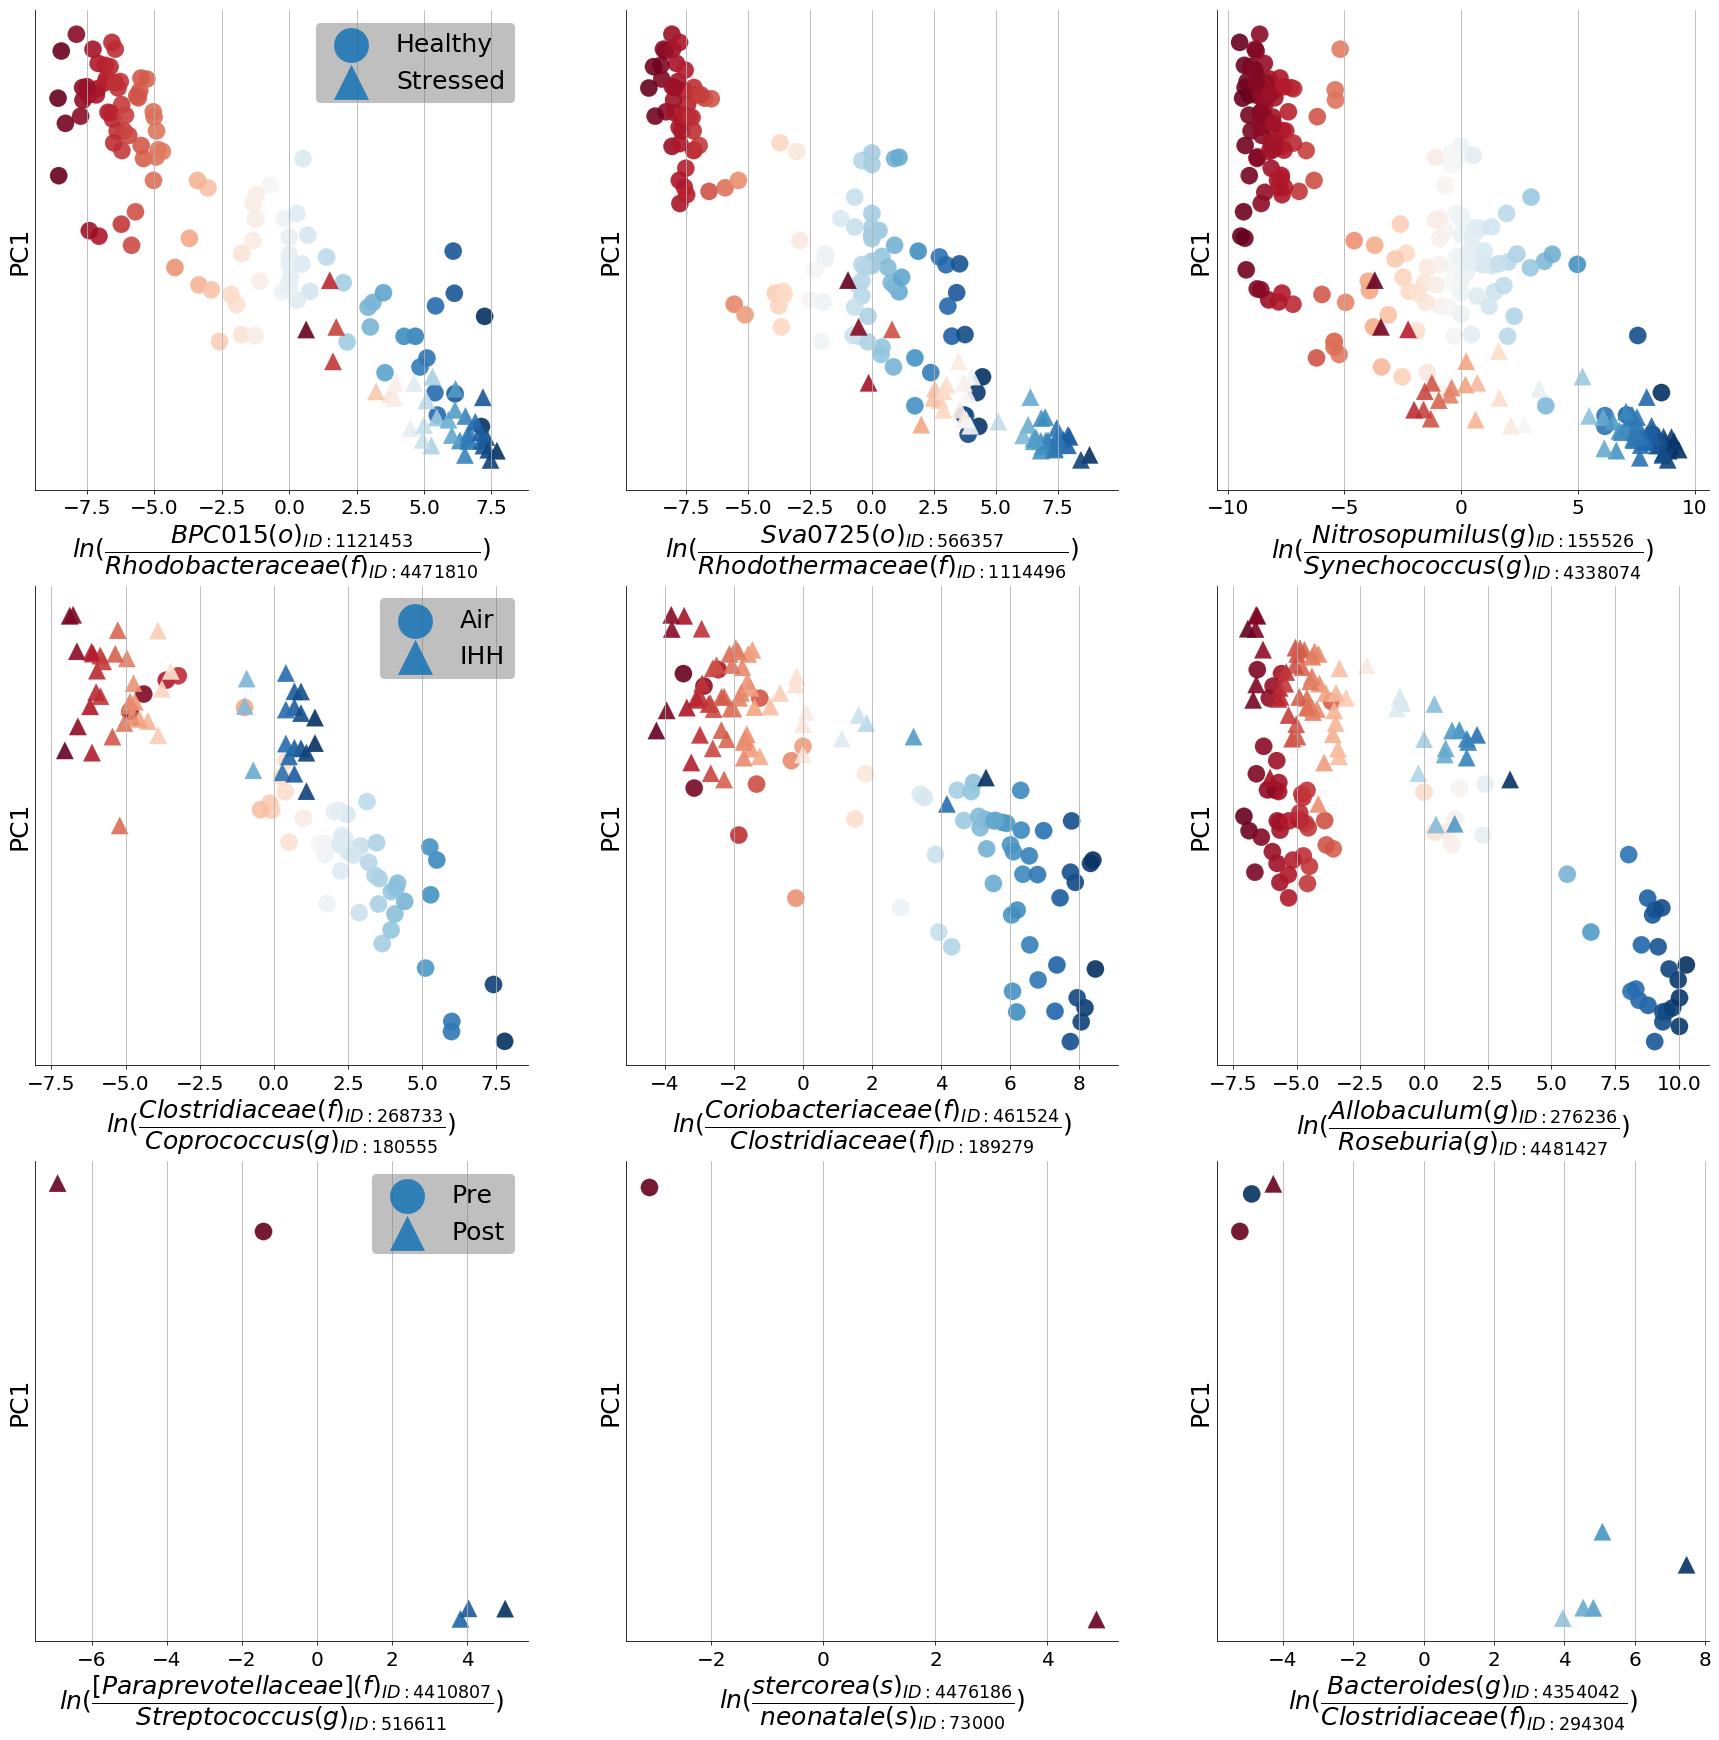

In [256]:
fig,axn=plt.subplots(3,3,figsize=(30,30))
axn=axn.flat
count_=0
for study_ in case_study.keys(): 
    for ratio_ in case_study[study_]['lr_list'][::-1]:
        
        lr_tmp=case_study[study_]['lr'].dropna(subset=[case_study[study_]['lr_list'][0]])
        
        plot_biplot(lr_tmp,  lr_tmp, 
                    axn[count_], case_study[study_]['factor'], ratio_)

        axn[count_].set_xlabel('$'+ratio_+'$',fontsize=25)
        axn[count_].set_ylabel('PC1',fontsize=25)
        if count_ in [0,3,6]:
            axn[count_].legend(loc='best',prop={'size':25},
                         fancybox=True, framealpha=0.5,ncol=1
                         , markerscale=2, facecolor="grey")
        count_+=1
        
fig.savefig('figures/figure4.png',dpi=300, 
            bbox_inches='tight',facecolor='white')
plt.show()
